<a href="https://colab.research.google.com/github/nrohrbach/KeyFiguresElectricalInstallations/blob/main/KeyFiguresElectricalInstallations36kV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kennzahlen Geobasisdatensatz Elektrische Anlagen mit einer Nennspannung von über 36kV

---

Notebook um Kennzahlen des Geobasisdatensatzes "Elektrische Anlagen mit einer Nennspannung von über 36kV abzuleiten.






In [ ]:
#pip install geopandas

In [ ]:
#pip install datetime

In [ ]:
#pip install numpy

In [ ]:
#pip install owslib

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from owslib.wfs import WebFeatureService
from requests import Request

In [11]:
# WFS-Domain (auf PROD schalten)
url = "https://integration.geodienste.ch/db/elektrische_anlagen_ueber_36kv_v1_0_0/deu"

# Initialize
wfs = WebFeatureService(url=url)

# Parameter für Datenfetching (Count 100 entfernen)
paramsLeitung = dict(service='WFS', version="2.0.0", request='GetFeature', typeName='leitung', outputFormat='geojson', startIndex=0)
paramsStation = dict(service='WFS', version="2.0.0", request='GetFeature', typeName='station_punkt', outputFormat='geojson', startIndex=0)
paramsMast = dict(service='WFS', version="2.0.0", request='GetFeature', typeName='mast', outputFormat='geojson', startIndex=0)

# Parse URL mit Parametern
urlleitung = Request('GET', url, params=paramsLeitung).prepare().url
urlstation = Request('GET', url, params=paramsStation).prepare().url
urlmast = Request('GET', url, params=paramsMast).prepare().url

# Daten als Dataframe lesen
leitung = gpd.read_file(urlleitung)
station = gpd.read_file(urlstation)
mast = gpd.read_file(urlmast)

In [12]:
# Mapping auf bestehendes Datenmodell
dfLeitung = leitung.rename(columns ={
                         'id':'xtf_id',
                         'bezeichnung':'Bezeichnung',
                         'eigentuemer':'Eigentuemer',
                         'eigentum_vollstaendig':'EigentumVollstaendig',
                         'lagegenauigkeit':'Lagegenauigkeit',
                         'stromnetz_typ':'StromnetzTyp',
                         'leitung_typ':'LeitungTyp',
                         'spannung':'Spannung',
                         'betriebsstatus':'Betriebsstatus',
                         'frequenz':'Frequenz'})

dfStation = station.rename(columns ={
                        'id':'xtf_id',
                        'bezeichnung':'Bezeichnung',
                        'eigentuemer':'Eigentuemer',
                        'eigentum_vollstaendig':'EigentumVollstaendig',
                        'lagegenauigkeit':'Lagegenauigkeit',
                        'stromnetz_typ':'StromnetzTyp',
                        'station_typ': 'StationTyp'})

dfMast = mast.rename(columns ={
                        'id':'xtf_id',
                        'bezeichnung':'Bezeichnung',
                        'eigentuemer':'Eigentuemer',
                        'eigentum_vollstaendig':'EigentumVollstaendig',
                        'lagegenauigkeit':'Lagegenauigkeit',
                        'stromnetz_typ':'StromnetzTyp',
                        'mast_typ':'MastTyp',
                        'hoehe':'Hoehe'})


In [13]:
#url = "https://data.geo.admin.ch/ch.bfe.elektrische-anlagen_ueber_36/gpkg/2056/ElektrischeAnlagenNennspannungUeber36kV_V1.gpkg"
#dfLeitung = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Leitung')
#dfStation = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Station')
#dfMast = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Mast')

## Kennzahlen Leitungen

In [14]:
# Länge der Leitungen berechnen und nach Spannung aufsummieren
dfLeitung["Laenge"] = dfLeitung.length
dfLeitungKPI = dfLeitung.groupby(['StromnetzTyp','Spannung','LeitungTyp'])['Laenge'].sum()
dfLeitungKPI = dfLeitungKPI.to_frame().reset_index()
dfLeitungKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [15]:
#Speichern
dfLeitungKPI.to_csv("data/Kennzahlen_Leitungen.csv", header=False, index=False, mode='a')

## Kennzahlen Masten

In [16]:
dfMastKPI = dfMast.groupby(['StromnetzTyp','MastTyp'])['xtf_id'].count().reset_index()
dfMastKPI = dfMastKPI.rename(columns={'xtf_id':'Anzahl'})
dfMastKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [17]:
#Speichern
dfMastKPI.to_csv("data/Kennzahlen_Masten.csv", header=False, index=False, mode='a')

## Kennzahlen Stationen

In [18]:
dfStationKPI = dfStation.groupby(['StromnetzTyp','StationTyp'])['xtf_id'].count().reset_index()
dfStationKPI = dfStationKPI.rename(columns={'xtf_id':'Anzahl'})
dfStationKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [19]:
#Speichern
dfStationKPI.to_csv("data/Kennzahlen_Stationen.csv", header=False, index=False, mode='a')

## Kennzahlen Werke

In [20]:
# Leitungslänge pro Werk ableiten.
dfWerkeLeitung = dfLeitung.groupby(['Eigentuemer','LeitungTyp'])['Laenge'].sum()
dfWerkeLeitung = dfWerkeLeitung.to_frame().reset_index()
dfWerkeLeitung = pd.pivot(dfWerkeLeitung,index='Eigentuemer',columns='LeitungTyp')
dfWerkeLeitung = dfWerkeLeitung.reset_index()
dfWerkeLeitung.columns = dfWerkeLeitung.columns.droplevel()
dfWerkeLeitung.columns = ['Werk','Freileitung','Kabelleitung']
dfWerkeLeitung = dfWerkeLeitung.fillna(0)
dfWerkeLeitung['LeitungGesamt']= dfWerkeLeitung['Kabelleitung']+dfWerkeLeitung['Freileitung']

In [21]:
# Anzahl Masten pro Werk ableiten.
dfWerkeMast = dfMast
dfWerkeMast['Werk'] = dfWerkeMast['Eigentuemer']
dfWerkeMast = dfWerkeMast.groupby(['Werk'])['xtf_id'].count().reset_index()
dfWerkeMast = dfWerkeMast.rename(columns={'xtf_id':'AnzahlMasten'})

In [22]:
# Anzahl Stationen pro Werk ableiten.
dfWerkeStation = dfStation
dfWerkeStation['Werk'] = dfWerkeStation['Eigentuemer']
dfWerkeStation = dfWerkeStation.groupby(['Werk'])['xtf_id'].count().reset_index()
dfWerkeStation = dfWerkeStation.rename(columns={'xtf_id':'AnzahlStationen'})

In [23]:
# Zusammenführen
dfWerke = pd.merge(dfWerkeLeitung, dfWerkeMast, how="outer", on=["Werk"])
dfWerke = pd.merge(dfWerke, dfWerkeStation, how="outer", on=["Werk"])
dfWerke = dfWerke.fillna(0)
dfWerke['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [24]:
#Speichern
dfWerke.to_csv("data/Kennzahlen_Werke.csv", header=False, index=False, mode='a')

### Kennzahlen für Visualisierung in Storymap ableiten

In [25]:
dfLeitungStorymap = dfLeitungKPI

# Gewünschte Kategorien definieren
Bedingungen = [dfLeitungStorymap['Spannung']=='S380kV',
               dfLeitungStorymap['Spannung']=='S220kV',
               (dfLeitungStorymap['StromnetzTyp']=='Allgemeinstrom') & (dfLeitungStorymap['Spannung'].isin(['S150kV','S132kV','S130kV','S125kV','S110kV'])),
               (dfLeitungStorymap['StromnetzTyp']=='Allgemeinstrom') & (dfLeitungStorymap['Spannung'].isin(['S66kV','S65kV','S60kV','S50kV','S36kV','Andere'])),
               (dfLeitungStorymap['StromnetzTyp']=='Bahnstrom') & (dfLeitungStorymap['Spannung']=='S132kV'),
               (dfLeitungStorymap['StromnetzTyp']=='Bahnstrom') & (dfLeitungStorymap['Spannung'].isin(['S66kV','Andere']))
               ]

Spannungen = ['s380','s220','s150','s66','s132B','s66B']

# Neues Attribut "Kategorie" erstellen welches für alle Objekte die gewünschte Kategorie bestimmt
dfLeitungStorymap['Kategorie'] =  np.select(Bedingungen,Spannungen)

In [26]:
# Dataframe für Totale Länge vorbereiten
dfTotal = dfLeitungStorymap.groupby('Kategorie').sum(numeric_only=True).reset_index()
dfTotal['Kategorie'] = 'Total_'+ dfTotal['Kategorie']
dfTotal = dfTotal.transpose()
dfTotal.columns = dfTotal.iloc[0]
dfTotal = dfTotal[1:]
dfTotal['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [27]:
# Dataframe für Länge von Kabel vorbereiten
dfKabel = dfLeitungStorymap.loc[dfLeitungStorymap['LeitungTyp']=='Kabelleitung'].groupby('Kategorie').sum(numeric_only=True).reset_index()
dfKabel['Kategorie'] = 'Kabel_'+ dfKabel['Kategorie']
dfKabel = dfKabel.transpose()
dfKabel.columns = dfKabel.iloc[0]
dfKabel = dfKabel[1:]
dfKabel['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [28]:
# Zusammenführen
dfStorymap = pd.merge(dfTotal, dfKabel, how='left', on=["Datum"])

In [29]:
#Temporäre Platzhalter für die Bahnstromkategorien erstellen. kann später gelöscht werden!
dfStorymap['Total_s132B'] = 1
dfStorymap['Kabel_s132B'] = 1
dfStorymap['Total_s66B'] = 1
dfStorymap['Kabel_s66B'] = 1

In [30]:
#Speichern
dfStorymap.to_csv("data/Kennzahlen_Storymap.csv", header=False, index=False, mode='a')

### Visualisierungen Werke

In [31]:
#Daten für Visualisierung laden
df = pd.read_csv("data/Kennzahlen_Werke.csv", parse_dates=['Datum'])
dfVis = df
dfVis['Freileitung'] = dfVis['Freileitung']/1000
dfVis['Kabelleitung'] = dfVis['Kabelleitung']/1000
dfVis['LeitungGesamt'] = dfVis['LeitungGesamt']/1000
dfVis['Freileitung'] = dfVis['Freileitung'].round(0)
dfVis['Kabelleitung'] = dfVis['Kabelleitung'].round(0)
dfVis['LeitungGesamt'] = dfVis['LeitungGesamt'].round(0)
dfVis = df.loc[df['Datum'] == datetime.today().strftime("%Y-%m-%d")]

#### Anzahl Masten pro Werkbetreiber

In [47]:
#Barchart Anzahl Masten
dfVisMast = dfVis[dfVis["AnzahlMasten"]>0]
dfVisMast = dfVisMast.sort_values('AnzahlMasten',ascending=False)
fig, ax = plt.subplots()
ax.bar(dfVisMast['Werk'], dfVisMast['AnzahlMasten'])
ax.set_title('Anzahl Masten')
plt.xticks(rotation = 90)
plt.ylabel("Anzahl Masten")
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig('plots/AnzahlMasten.png',bbox_inches='tight')
plt.close()

#### Anzahl Stationen pro Werkbetreiber

In [49]:
#Barchart Anzahl Stationen
dfVisStationen = dfVis[dfVis["AnzahlStationen"]>0]
dfVisStationen = dfVisStationen.sort_values('AnzahlStationen',ascending=False)
fig, ax = plt.subplots()
ax.bar(dfVisStationen['Werk'], dfVisStationen['AnzahlStationen'])
ax.set_title('Anzahl Stationen')
plt.xticks(rotation = 90)
plt.ylabel("Anzahl Stationen")
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig('plots/AnzahlStationen.png',bbox_inches='tight')
plt.close()

#### Länge der Leitungen pro Werkbetreiber

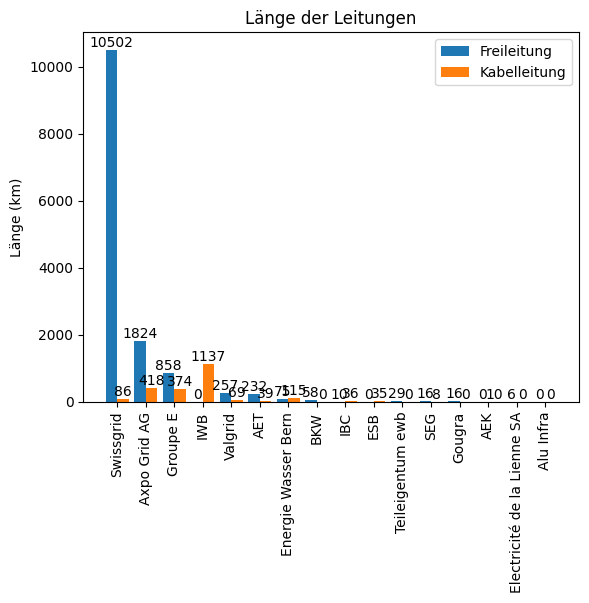

<Figure size 4000x1000 with 0 Axes>

In [58]:
#Barchart Länge Leitungen

dfVisLaenge = dfVis[dfVis["LeitungGesamt"]>0]
dfVisLaenge = dfVisLaenge.sort_values('LeitungGesamt',ascending=False)

#bar chart properties
x = np.arange(len(dfVisLaenge['Werk']))
width = 0.4

#draw grouped bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, dfVisLaenge['Freileitung'], width, label='Freileitung')
bar2 = ax.bar(x + width/2, dfVisLaenge['Kabelleitung'], width, label='Kabelleitung')

#ax.set_xlabel('Year')
ax.set_ylabel('Länge (km)')
ax.set_title('Länge der Leitungen')
ax.set_xticks(x, dfVisLaenge['Werk'])
ax.legend()

#setting bar labels
ax.bar_label(bar1)
ax.bar_label(bar2)
plt.xticks(rotation = 90)

plt.figure(figsize=(40,10))
plt.savefig('plots/LaengeLeitungen.png',bbox_inches='tight')
#plt.close()

### Visualisierungen Masten

In [ ]:
#Zeitliche Entwicklung Anzahl Masten
dfAnzahlMasten = pd.read_csv("data/Kennzahlen_Masten.csv", parse_dates=['Datum'])
dfAnzahlMastenEntwicklung = dfAnzahlMasten.pivot(index="Datum", columns=["MastTyp","StromnetzTyp"],values="Anzahl")
dfAnzahlMastenEntwicklung.plot(figsize=(15,10))
plt.legend(loc='lower left')
plt.title("Übersicht Anzahl Masten")
plt.savefig('plots/UebersichtAnzahlMasten.png')
plt.close()

### Visualisierung Stationen

In [ ]:
#Zeitliche Entwicklung Anzahl Stationen
dfAnzahlStationen = pd.read_csv("data/Kennzahlen_Stationen.csv", parse_dates=['Datum'])
dfAnzahlStationen = dfAnzahlStationen.pivot(index="Datum", columns=["StationTyp","StromnetzTyp"],values="Anzahl")
dfAnzahlStationen.plot(figsize=(15,10))
plt.legend(loc='lower left')
plt.title("Übersicht Anzahl Stationen")
plt.savefig('plots/UebersichtAnzahlStationen.png')
plt.close()

### Visualisierung Leitungen


In [ ]:
#Zeitliche Entwicklung Länge der Leitungen - Daten vorbereiten
dfLaengeLeitungen = pd.read_csv("data/Kennzahlen_Leitungen.csv", parse_dates=['Datum'])
dfLaengeLeitungen['Laenge'] = dfLaengeLeitungen['Laenge']/1000
dfLaengeLeitungen['Laenge'] = dfLaengeLeitungen['Laenge'].round(0)

#### Leitungslänge pro Leitungstyp - zeitliche Entwicklung

In [ ]:
#Zeitliche Entwicklung Länge der Leitungen - Leitungstyp
dfLaengeLeitungTyp = dfLaengeLeitungen.groupby(['LeitungTyp','Datum'])['Laenge'].sum().reset_index()
dfLaengeLeitungTyp = dfLaengeLeitungTyp.pivot(index="Datum", columns=["LeitungTyp"],values="Laenge")
dfLaengeLeitungTyp.plot(figsize=(15,10))
plt.legend(loc='lower left')
plt.title("Länge der Leitungen (km) - Leitungstyp")
plt.savefig('plots/LaengeLeitungen_Typ.png')
plt.close()

#### Leitungslänge pro Spannungsebene - zeitliche Entwicklung

In [ ]:
#Zeitliche Entwicklung Länge der Leitungen - Spannung
dfLaengeLeitungTyp = dfLaengeLeitungen.groupby(['Spannung','Datum'])['Laenge'].sum().reset_index()
dfLaengeLeitungTyp = dfLaengeLeitungTyp.pivot(index="Datum", columns=["Spannung"],values="Laenge")
dfLaengeLeitungTyp.plot(figsize=(15,10))
plt.legend(loc='lower left')
plt.title("Länge der Leitungen (km) - Spannung")
plt.savefig('plots/LaengeLeitungen_Spannung.png')
plt.close()

#### Leitungslänge pro Stromnetztyp - zeitliche Entwicklung

In [ ]:
#Zeitliche Entwicklung Länge der Leitungen - StromnetzTyp
dfLaengeLeitungTyp = dfLaengeLeitungen.groupby(['StromnetzTyp','Datum'])['Laenge'].sum().reset_index()
dfLaengeLeitungTyp = dfLaengeLeitungTyp.pivot(index="Datum", columns=["StromnetzTyp"],values="Laenge")
dfLaengeLeitungTyp.plot(figsize=(15,10))
plt.legend(loc='lower left')
plt.title("Länge der Leitungen (km) - StromnetzTyp")
plt.savefig('plots/LaengeLeitungen_StromnetzTyp.png')
plt.close()

#### Leitungslänge nach Spannung

In [ ]:
#Barchart Länge Leitungen nach Spannung

#Nur aktuellste Zeile
dfLaengeLeitungen = dfLaengeLeitungen.loc[dfLaengeLeitungen['Datum'] == datetime.today().strftime("%Y-%m-%d")]

#Daten vorbereiten
dfLeitungenBarChart = dfLaengeLeitungen.pivot_table(index='Spannung',columns=['LeitungTyp'],values='Laenge', aggfunc='sum').reset_index()
dfLeitungenBarChart = dfLeitungenBarChart.fillna(0)
dfLeitungenBarChart['Spannung'] = dfLeitungenBarChart['Spannung'].replace({'S':''},regex=True)
dfLeitungenBarChart = dfLeitungenBarChart.sort_values('Freileitung',ascending=False)

#bar chart properties
x = np.arange(len(dfLeitungenBarChart['Spannung']))
width = 0.3

#draw grouped bar chart
fig, ax = plt.subplots(figsize=(15,10))
bar1 = ax.bar(x - width/2, dfLeitungenBarChart['Freileitung'], width, label='Freileitung')
bar2 = ax.bar(x + width/2, dfLeitungenBarChart['Kabelleitung'], width, label='Kabelleitung')

#ax.set_xlabel('Year')
ax.set_ylabel('Länge (km)')
ax.set_title('Länge der Leitungen')
ax.set_xticks(x, dfLeitungenBarChart['Spannung'])

#setting bar labels
ax.bar_label(bar1)
ax.bar_label(bar2)
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.savefig('plots/LaengeLeitungen_Spannung_Uebersicht.png',bbox_inches='tight')
plt.close()

#### Masttyp Übersicht

In [ ]:
#Daten vorbereiten
dfAnzahlMastenUebersicht = dfAnzahlMasten
dfAnzahlMastenUebersicht = dfAnzahlMastenUebersicht.loc[dfAnzahlMastenUebersicht['Datum'] == datetime.today().strftime("%Y-%m-%d")]

#Barchart
x = np.arange(len(dfAnzahlMastenUebersicht['MastTyp']))
fig, ax = plt.subplots(figsize=(15,10))
bar1 = ax.bar(x, dfAnzahlMastenUebersicht['Anzahl'], label='MastTyp')
ax.set_ylabel('Anzahl Masten')
ax.set_title('Anzahl Masten')
ax.set_xticks(x, dfAnzahlMastenUebersicht['MastTyp'])
ax.bar_label(bar1)
plt.savefig('plots/AnzahlMasten_Uebersicht.png',bbox_inches='tight')
plt.close()